In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#RUN BEFORE#

In [31]:
#RUN AFTER#

import tensorflow.keras as keras
K = keras.backend
from util.Models import *
from util.Generators import *
from util.Plotting import *


In [5]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'


In [6]:

K.clear_session()
model = GarNetModel(alpha=0.99)


2023-06-01 21:18:16.594989: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-01 21:18:16.595076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


Model: "gar_net_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 4)]     0                                            
__________________________________________________________________________________________________
input_gex (GlobalExchange)      (None, 128, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
input_batchnorm (BatchNormaliza (None, 128, 8)       32          input_gex[0][0]                  
__________________________________________________________________________________________________
input_dense (Dense)             (None, 128, 8)       72          input_batchnorm[0][0]            
______________________________________________________________________________________

In [7]:

train_val_split = 0.8
batch_size = 64

pi0_list = [[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] 
            for i in list(range(11, 113)) + list(range(116, 232))]
pipm_list = [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] 
             for i in list(range(11, 113)) + list(range(116, 232))]

np.random.shuffle(pi0_list)
np.random.shuffle(pipm_list)

train_start = 0
train_end = train_start + int(train_val_split*len(pi0_list))
val_start = train_end
val_end = len(pi0_list)
train_file_list = (pi0_list[train_start:train_end], pipm_list[train_start:train_end])
val_file_list = (pi0_list[val_start:val_end], pipm_list[val_start:val_end])

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(232, 264)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(232, 264)])


In [8]:

train_generator = garnetDataGenerator(train_file_list, 
                                      cell_geo_path, 
                                      batch_size, 
                                      labeled=True, 
                                      preprocess=False, 
                                      output_dir=out_path + 'train/')

validation_generator = garnetDataGenerator(val_file_list, 
                                           cell_geo_path, 
                                           int(batch_size*(1 - train_val_split)/train_val_split), 
                                           labeled=True, 
                                           preprocess=False, 
                                           output_dir=out_path + 'val/')

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=1000,
                                     labeled=True,
                                     preprocess=False,
                                     output_dir=out_path + 'test/')


In [9]:

history = model.fit(train_generator.generator(), 
                    validation_data=validation_generator.generator(),
                    steps_per_epoch=800,
                    validation_steps=200,
                    shuffle=True,
                    epochs=100,
                    verbose=2)

model.save(out_path + 'models/GarNet')

with open(out_path + 'models/GarNet/history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

2023-06-01 21:18:25.629533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
800/800 - 25s - loss: 0.6475 - accuracy: 0.5677 - val_loss: 0.6575 - val_accuracy: 0.5277
Epoch 2/100
800/800 - 18s - loss: 0.5528 - accuracy: 0.6833 - val_loss: 0.5450 - val_accuracy: 0.5790
Epoch 3/100
800/800 - 18s - loss: 0.5297 - accuracy: 0.7013 - val_loss: 0.5302 - val_accuracy: 0.5820
Epoch 4/100
800/800 - 19s - loss: 0.5111 - accuracy: 0.7127 - val_loss: 0.5021 - val_accuracy: 0.6180
Epoch 5/100
800/800 - 19s - loss: 0.4961 - accuracy: 0.7115 - val_loss: 0.4653 - val_accuracy: 0.7010
Epoch 6/100
800/800 - 19s - loss: 0.4856 - accuracy: 0.7101 - val_loss: 0.5583 - val_accuracy: 0.7187
Epoch 7/100
800/800 - 19s - loss: 0.4830 - accuracy: 0.6972 - val_loss: 0.4766 - val_accuracy: 0.6120
Epoch 8/100
800/800 - 18s - loss: 0.4714 - accuracy: 0.6977 - val_loss: 0.4525 - val_accuracy: 0.6480
Epoch 9/100
800/800 - 19s - loss: 0.4744 - accuracy: 0.6846 - val_loss: 0.4848 - val_accuracy: 0.6070
Epoch 10/100
800/800 - 19s - loss: 0.4715 - accuracy: 0.6779 - val_loss: 0.4710 - 

2023-06-01 21:49:09.045479: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet/assets


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet/assets


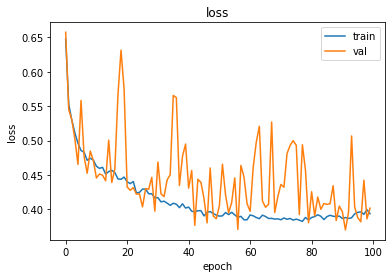

In [11]:
loss_curve = Plotter(training, history=history, metric='loss')
loss_curve.show()

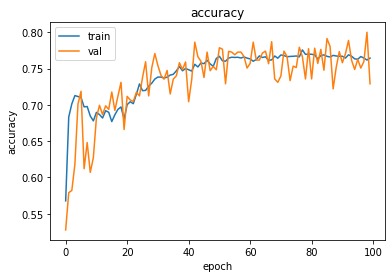

In [12]:
accuracy_curve = Plotter(training, history=history, metric='accuracy')
accuracy_curve.show()

In [13]:
x, y = next(test_generator.generator())

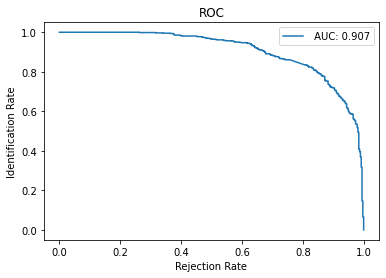

In [35]:
ROC = Plotter(roc, pred=model.predict(x)[:,0], target=y[:,0])
ROC.show()

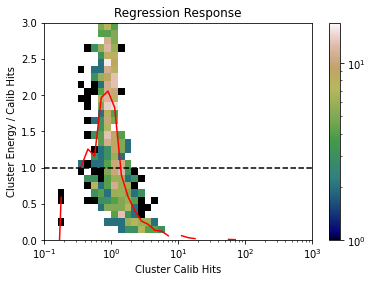

In [40]:
reg = Plotter(regResponse, pred=model.predict(x)[:,-1], target=y[:,-1])
reg.show()